Import the dataset

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

boston = pd.read_csv("http://lib.stat.cmu.edu/datasets/boston", sep="\s+", skiprows=22, header=None)
data = np.hstack([boston.values[::2, :], boston.values[1::2, :2]])
target = boston.values[1::2, 2]
features = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])

print(data.shape)
print(target.shape)

(506, 13)
(506,)


Data preparation

In [2]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(354, 13)
(152, 13)
(354, 1)
(152, 1)


Scikit Linear Regression

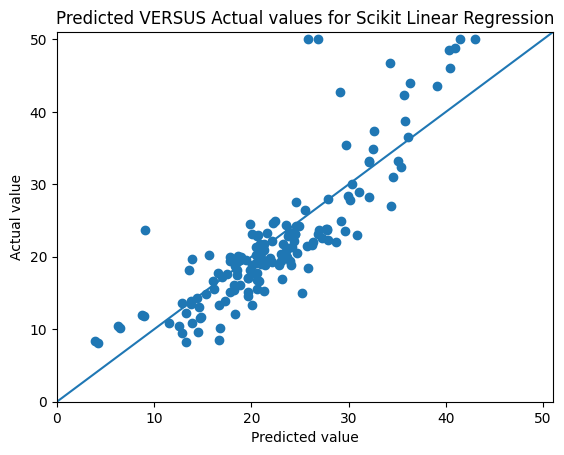

In [3]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(x_train, y_train)
preds = lr.predict(x_test)

import matplotlib.pyplot as plt
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted VERSUS Actual values for Scikit Linear Regression")
plt.xlim([0,51])
plt.ylim([0,51])
plt.scatter(preds, y_test)
plt.plot([0,51],[0,51])

Error estimation

In [4]:
def mae(y, pred):
    """
    Compute Mean Absolute Error
    """
    error = np.mean(np.abs(y - pred))
    return error

def rmse(y, pred):
    """
    Compute Root Mean Squared Error
    """
    error = np.sqrt(np.mean(np.power(y - pred, 2)))
    return error

print(mae(y_test,preds))
print(rmse(y_test,preds))

3.5670558182093983
5.047566790461463


Manual Linear Regression

![Alt text](figure1.png)

In [5]:
def forward_loss(X, Y, params):
    # assert batch sizes of X and y are equal
    assert X.shape[0] == Y.shape[0]

    # assert that matrix multiplication can work
    assert X.shape[1] == params['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert params['B'].shape[0] == params['B'].shape[1] == 1

    forward_info = {}
    forward_info['X'] = X
    forward_info['Y'] = Y

    N = np.dot(X, params['W'])
    forward_info['N'] = N

    P = N + params['B']
    forward_info['P'] = P

    L = np.mean(np.power(Y - P, 2))

    return L, forward_info



In [6]:
def loss_gradients(forward_info, params):
    grads = {}

    dLdP = -2*(forward_info['Y'] - forward_info['P'])
    dPdN = np.ones_like(forward_info['N'])
    dNdW = np.transpose(forward_info['X'], (1, 0))
    dLdN = dLdP*dPdN
    dLdW = np.dot(dNdW,dLdN)
    grads['W'] = dLdW

    dPdB = np.ones_like(params['B'])
    dLdB = (dLdP * dPdB).sum(axis = 0)
    grads['B'] = dLdB

    return grads

In [7]:
def init_params(in_features):
    params = {}   

    W = np.random.randn(in_features, 1)
    B = np.random.randn(1, 1)

    params['W'] = W
    params['B'] = B

    return params

In [8]:
def permute_data(X, Y):
    '''
    Permute X and Y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], Y[perm]



In [9]:
def generate_batch(X,  
                   Y, 
                   start = 0,
                   batch_size = 10):
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == Y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, Y_batch = X[start:start+batch_size], Y[start:start+batch_size]
    
    return X_batch, Y_batch

In [10]:
def train_model(X, 
                Y, 
                epochs = 1000, 
                learning_rate = 0.01, 
                batch_size = 100, 
                return_losses = False, 
                return_weights = False, 
                seed = 1):
    if seed:
        np.random.seed(seed)
    start = 0

    #init params
    params = init_params(X.shape[1])

    #shuffle data
    X, Y = permute_data(X, Y)

    if return_losses:
        losses = []
    
    for i in range(epochs):
        # Generate batch
        if start >= X.shape[0]:
            X, Y = permute_data(X, Y)
            start = 0
        
        X_batch, Y_batch = generate_batch(X, Y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        loss, forward_info = forward_loss(X_batch, Y_batch, params)       

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, params)        

        for key in params.keys():
            params[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, params
    else:
        return None

In [11]:
train_info = train_model(x_train, y_train,
                   epochs= 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

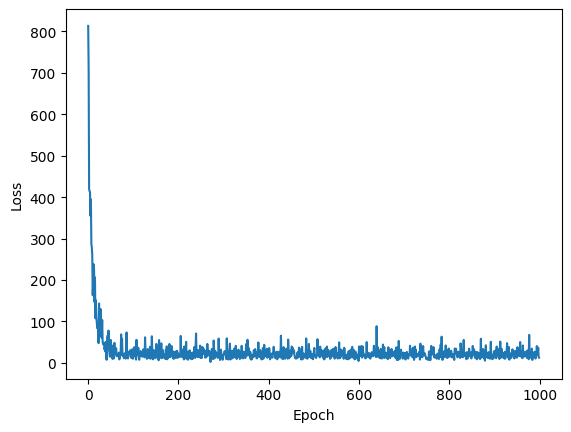

In [12]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(list(range(1000)), losses)

In [13]:
def predict(X, params):
    N = np.dot(X, params['W'])
    P = N + params['B']
    return P

preds = predict(x_test, weights)

print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5644 
Root mean squared error: 5.0497


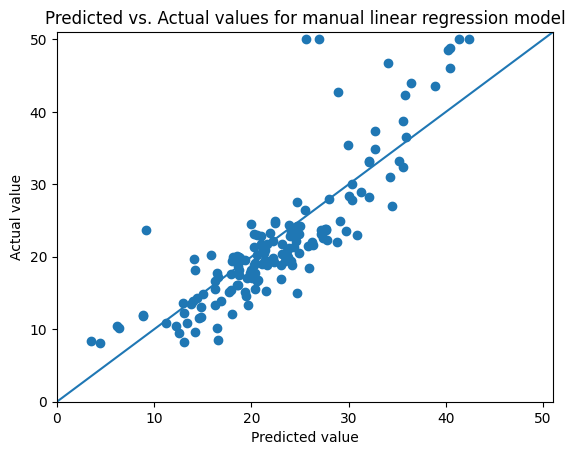

In [14]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for manual linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);